# Videos Generator

In [ ]:
!pip install keras-video-generators

In [ ]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator

In [ ]:
# use sub directories names as classes
classes = [i.split(os.path.sep)[8] for i in glob.glob('/content/drive/MyDrive/Drone-Action/datasets/Drone-Action-Dataset/Data/*')]
classes.sort()

In [ ]:
# some global params
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 8
BS = 16

In [ ]:
# pattern to get videos and classes
glob_pattern='/content/drive/MyDrive/Drone-Action/datasets/Drone-Action-Dataset/Data/{classname}/*.mp4'

In [ ]:
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    zoom_range=.2,
    horizontal_flip=True,
    rotation_range=8
    #width_shift_range=.2,
    #height_shift_range=.2
    )

In [ ]:
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.2,
    split_test = .2 ,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

class boxing, validation count: 4, test count: 3, train count: 13
class clapping, validation count: 2, test count: 1, train count: 7
class hitting_bottle, validation count: 4, test count: 3, train count: 13
class hitting_stick, validation count: 4, test count: 3, train count: 13
class jogging_f_b, validation count: 4, test count: 3, train count: 13
class jogging_side, validation count: 4, test count: 3, train count: 13
class kicking, validation count: 4, test count: 3, train count: 13
class running_f_b, validation count: 4, test count: 3, train count: 13
class running_side, validation count: 4, test count: 3, train count: 13
class stabbing, validation count: 4, test count: 3, train count: 13
class walking_f_b, validation count: 4, test count: 3, train count: 13
class walking_side, validation count: 4, test count: 3, train count: 13
class waving_hands, validation count: 2, test count: 1, train count: 7
Total data: 13 classes for 157 files for train


In [ ]:
valid = train.get_validation_generator()

Total data: 13 classes for 48 files for validation


In [ ]:
test = train.get_test_generator()

Total data: 13 classes for 35 files for test


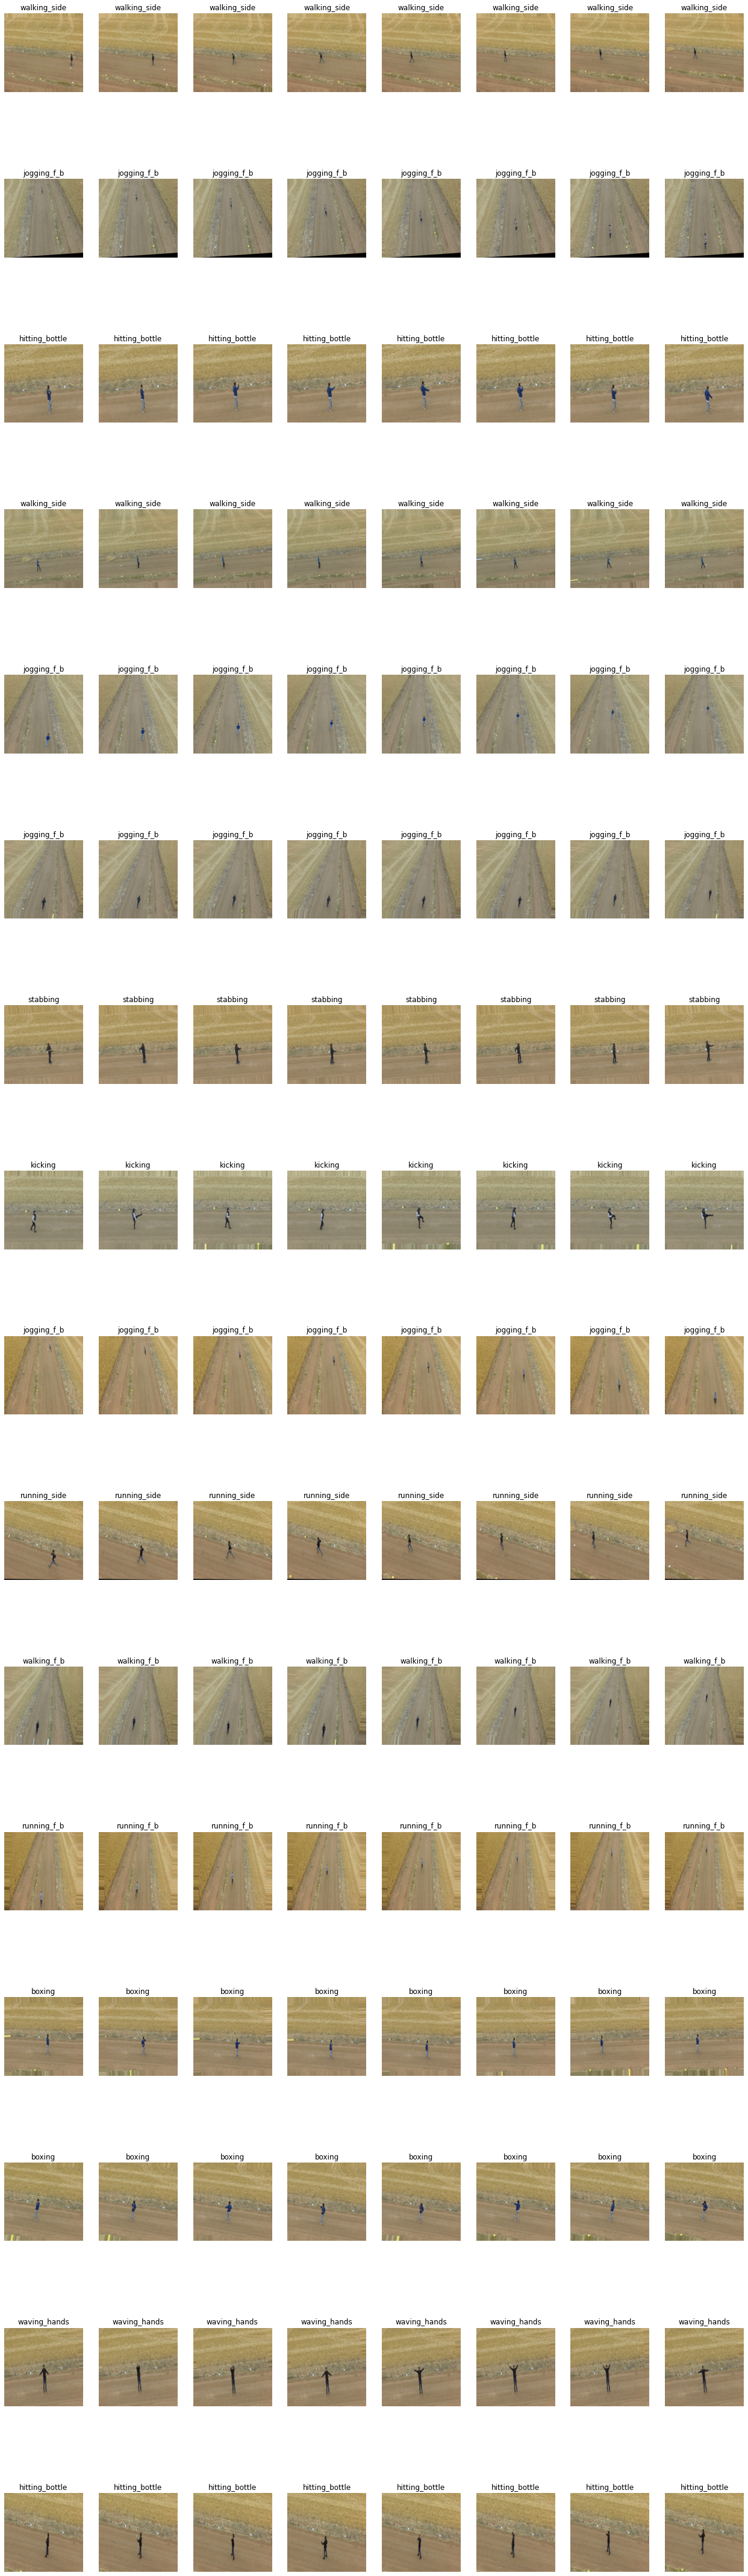

In [ ]:
import keras_video.utils
keras_video.utils.show_sample(train)

# Building the model shown in the picture below using Transfer Learning

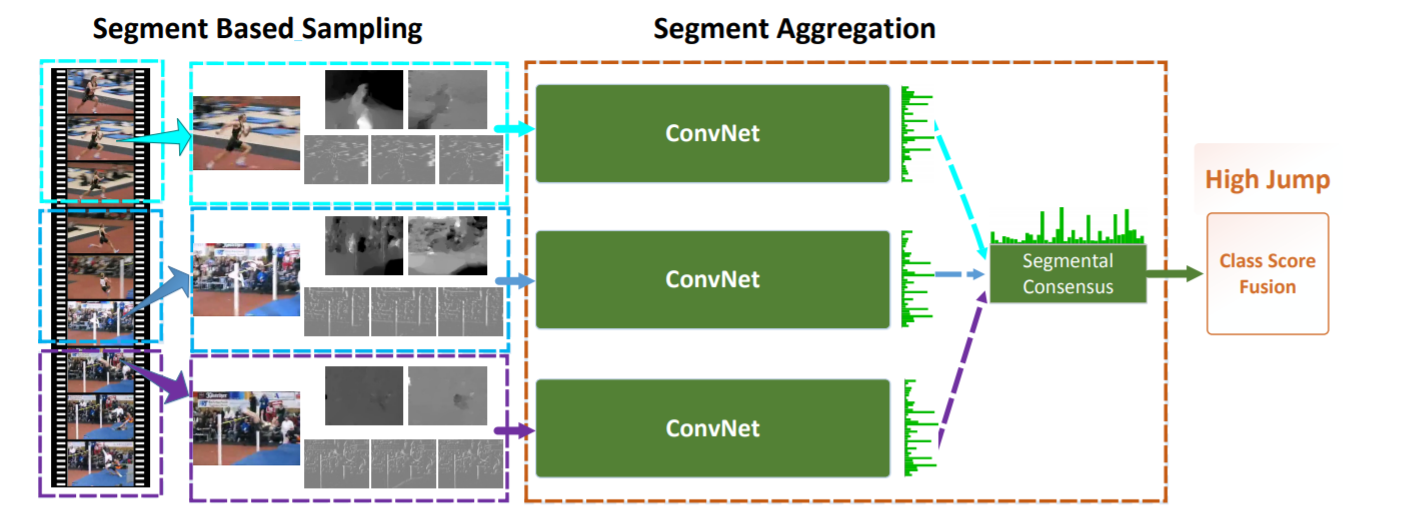

In [ ]:
import tensorflow as tf

inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3)
)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
inceptionv3.summary()

In [ ]:
import keras
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, \
    Flatten, TimeDistributed, Conv2D, Dropout, GlobalAveragePooling2D
from keras import Sequential

# do not train first layers, I want to only train
# the 4 last layers
for layer in inceptionv3.layers[:-4]:
  layer.trainable = False
# create a Sequential model
model = Sequential()
# add vgg model for 5 input images (keeping the right shape)
model.add(
    TimeDistributed(inceptionv3, input_shape=(8, 224, 224, 3))
)

model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(TimeDistributed(Dense(512, activation='relu')))
model.add(TimeDistributed(Dropout(.5)))
model.add(TimeDistributed(Dense(13, activation='softmax')))
model.add(GlobalAveragePooling1D())
#model.add(Dropout(.5))
#model.add(Dense(20, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 8, 5, 5, 2048)     21802784  
_________________________________________________________________
time_distributed_4 (TimeDist (None, 8, 2048)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 8, 512)            1049088   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 8, 512)            0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 8, 13)             6669      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 13)                0         
Total params: 22,858,541
Trainable params: 1,055,757
Non-trainable params: 21,802,784
__________________________________

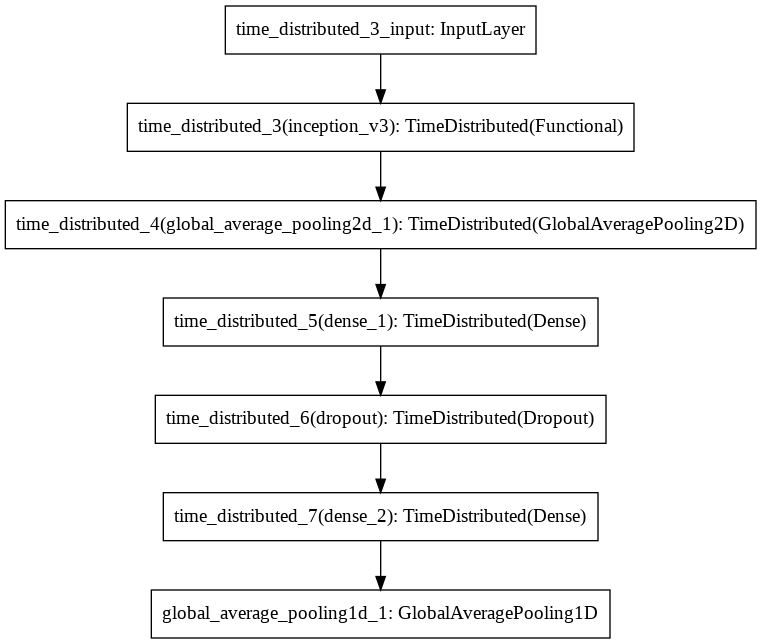

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
model.compile('sgd', 
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
EPOCHS=10
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    #keras.callbacks.ModelCheckpoint(
    #    'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    #    verbose=1),
]

In [ ]:
model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

In [ ]:
model.save('/content/drive/MyDrive/Drone-Action/Models')

In [ ]:
model.evaluate(valid)